In [ ]:
import numpy as np
import pandas as pd
import os

import csv

In [ ]:
os.getcwd()

'/Users/manix'

In [ ]:
data = pd.read_csv('/Users/manix/desktop/Modulo8DataMiningII/TrabajoFinal/train.csv')

In [ ]:
data.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28709 entries, 0 to 28708
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  28709 non-null  int64 
 1   pixels   28709 non-null  object
dtypes: int64(1), object(1)
memory usage: 448.7+ KB


Podemos ver el desbalanceo hacia Happy

In [ ]:
data["emotion"].value_counts(sort=True)

3    7215
6    4965
4    4830
2    4097
0    3995
5    3171
1     436
Name: emotion, dtype: int64

In [ ]:
#Pre Procesado de la Data
fer_alto = 48
fer_ancho= 48
Emotions =["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

In [ ]:
import matplotlib.pyplot as plt

funcion para ver una imagen

In [ ]:
def fer2013_show_instance(index):
    """Shows the image and the emotion label of the index's instance."""
    image = np.reshape(data.at[index, "pixels"].split(" "), (fer_ancho, fer_alto)).astype("float")
    image -= np.mean(image)
    image /= np.std(image)
    print(Emotions[data.at[index, "emotion"]])
    plt.imshow(image, cmap="gray")

Happy


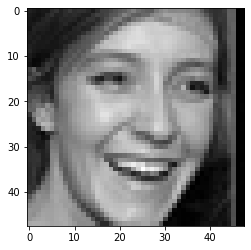

In [ ]:
fer2013_show_instance(np.random.randint(0,len(data)))

In [ ]:
#Preproceamiento de la data, la convertimos en arrays
X = data.pixels.apply(lambda x: np.array(x.split(' ')).astype('float32'))
X = np.stack(X, axis=0)
Y = np.array(data['emotion'])

In [ ]:
#Vemos que tenemos una alta dimensionalidad
X.shape

(28709, 2304)

In [ ]:
Y.shape

(28709,)

In [ ]:
# Importamos clasificadores y metricas de sklearn
from sklearn.svm import SVC

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA

In [ ]:
#Dividimos la data en entrenamiento y validación
X_train, X_valid, y_train, y_valid = train_test_split(X, Y,
                                                    shuffle=True, stratify=Y,
                                                    test_size=0.2, random_state=2)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((22967, 2304), (5742, 2304), (22967,), (5742,))

In [ ]:
# Hacemos reduccion de dimensionalidad a traves de un PCA de 2304 atributos a 267
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.astype(np.float32))
X_valid = scaler.transform(X_valid.astype(np.float32))
pca = PCA(n_components=.95)
pca.fit(X_train)
X_val_p = pca.transform(X_valid)
X_train_p = pca.transform(X_train)
scaler = StandardScaler()
X_train_p = scaler.fit_transform(X_train_p.astype(np.float32))
X_val_p = scaler.transform(X_val_p.astype(np.float32))
X_train_p.shape ,X_val_p.shape

((22967, 267), (5742, 267))

In [ ]:
# SVM
model = SVC(kernel = 'linear')
model.fit(X_train_p,y_train)
model.score(X_val_p , y_valid)

0.36955764541971436

In [ ]:
# SVM Con un Kernel Diferente
model = SVC(kernel ='rbf')
model.fit(X_train_p,y_train)
model.score(X_val_p , y_valid)

0.43521421107628006

In [ ]:
# KNN. No usamos la data de entrenamiento procesada por el PCA
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors=1)
classifier.fit(X_train, y_train)
classifier.score(X_valid,y_valid)

0.38523162661093696

In [ ]:
y_pred = classifier.predict(X_valid)

In [ ]:
import seaborn as sns

In [ ]:
# Creamos una Funcion para hacer matrices de Confusion
def create_confmat(true_labels, predicted_labels, columns, colour = 'Greens', size = (20,14)):
    sns.set(font_scale=1.5)
    cm = confusion_matrix(true_labels, predicted_labels)
    cm_df = pd.DataFrame(cm,
    index = [col for col in columns],
    columns = [col for col in columns])
    plt.figure(figsize=(18,16))
    sns.heatmap(cm_df, annot = True, cmap = colour, fmt='g', linewidths=.2)
    plt.title('Confusion Matrix', fontsize = 20)
    plt.ylabel('True label', fontsize = 18)
    plt.xlabel('Predicted label', fontsize = 18)
    plt.tick_params(axis='both', labelsize=14)
    plt.show()

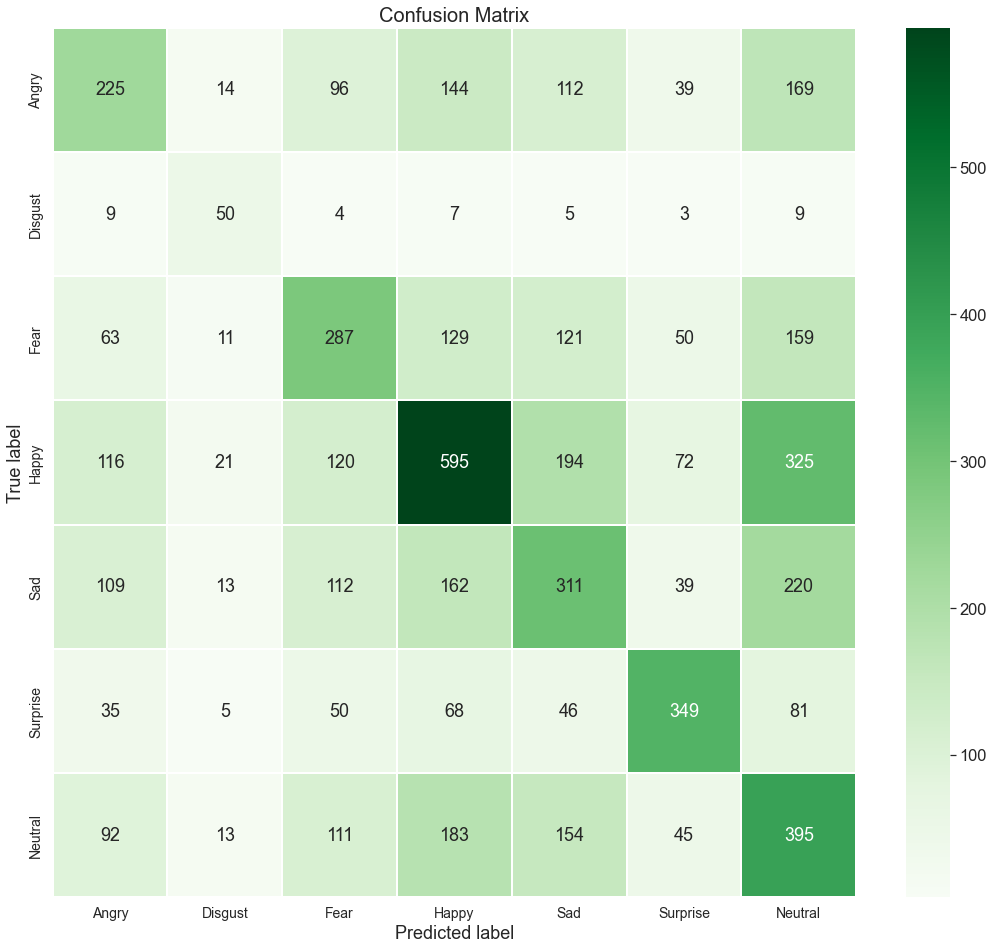

In [ ]:
create_confmat(y_valid,y_pred,Emotions)

In [ ]:
y_pred2 = model.predict(X_val_p)

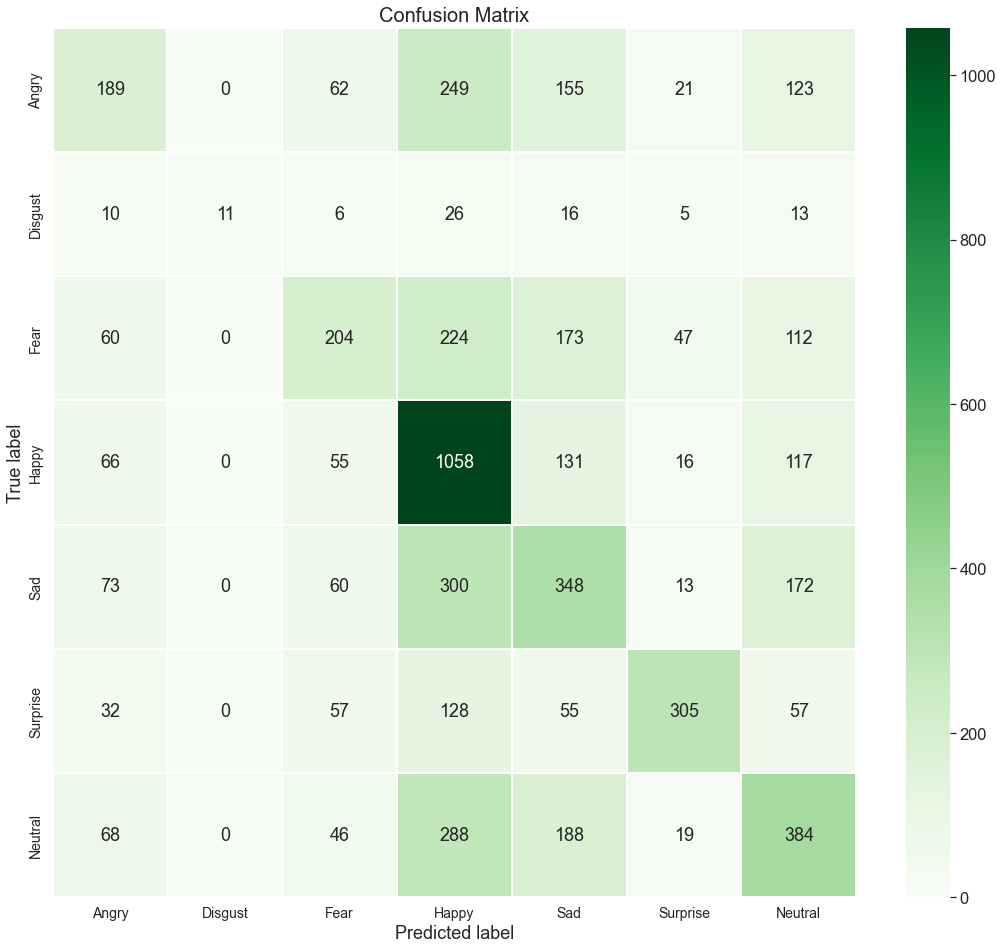

In [ ]:
create_confmat(y_valid,y_pred2,Emotions)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X_train, y_train)
clf.score(X_valid, y_valid)

0.27412051549982586

In [ ]:
y_pred3 = clf.predict(X_valid)

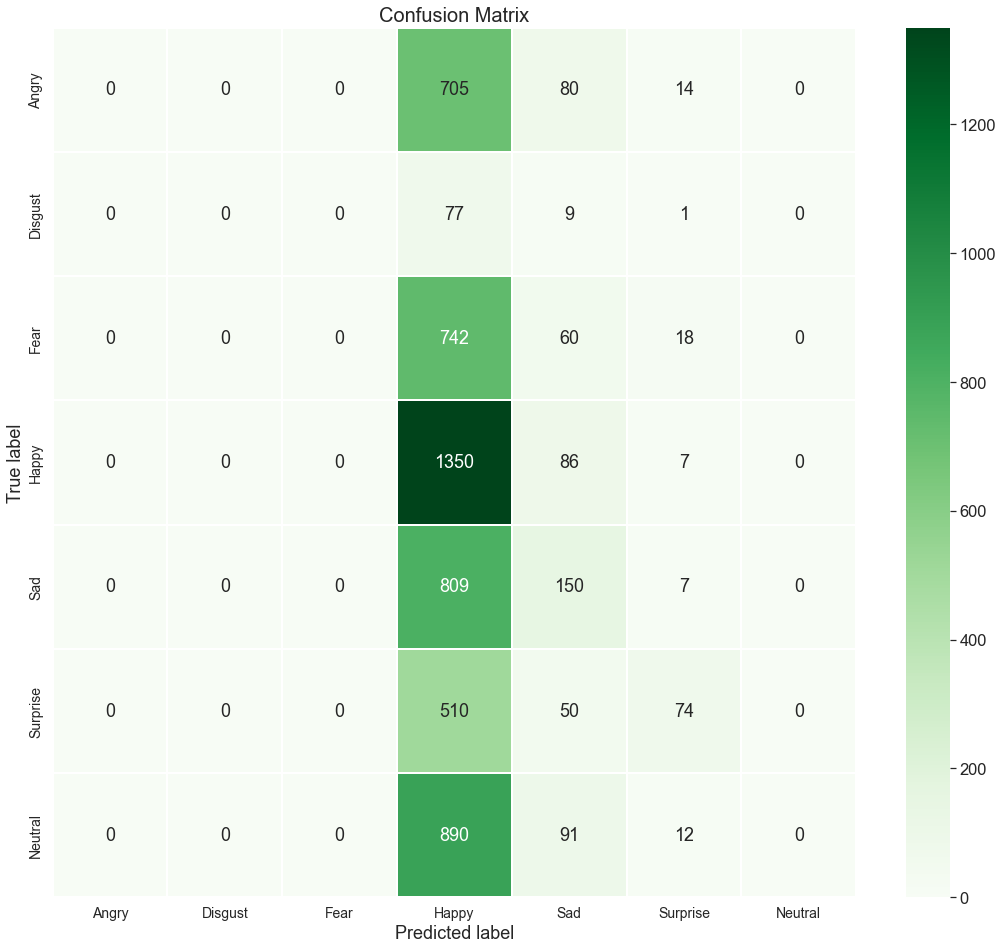

In [ ]:
create_confmat(y_valid, y_pred3, Emotions)

In [ ]:
from sklearn import svm, metrics

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

# Specify the ranges to be searched for hyper-parameters
C_range = np.logspace(-2, 10, 5)
gamma_range = np.logspace(-9, 3, 5)
param_grid = dict(gamma=gamma_range, C=C_range)

# Do cross validation
cv = KFold() # default n_splits = 2
grid = GridSearchCV(svm.SVC(), param_grid=param_grid, cv=cv)
grid.fit(X_train_p, y_train)

print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))